# `CLOUD.jl` - 3D linear advection example

In [1]:
using CLOUD, OrdinaryDiffEq, Plots, Plots.PlotMeasures

┌ Info: Precompiling CLOUD [fb992021-99c7-4c2d-a14b-5e48ac4045b2]
└ @ Base loading.jl:1423


## Define the physical problem

In [2]:
θ = π/4 # wave angle
a = sqrt(2) # wave speed
A = 1.0  # amplitude
L = 1.0  # domain length
k = (2*π/L, 2*π/L, 2*π/L)  # wave number
T = 1.0/(a*max(abs(cos(θ)),abs(sin(θ)))) # end time for one period

conservation_law = LinearAdvectionEquation((a*cos(θ),a*sin(θ),0.0))
initial_data = InitialDataCosine(A,k)
exact_solution = ExactSolution(conservation_law,initial_data);

## Set discretization parameters

In [3]:
M = 4
p = 4
p_map = 2
form = WeakConservationForm(mapping_form=StandardMapping(), 
    inviscid_numerical_flux=LaxFriedrichsNumericalFlux(1.0))
strategy = PhysicalOperator()

ode_algorithm = CarpenterKennedy2N54()
dt = 0.25*(L/M)/(a*(2*p+1));
write_interval = floor(Int, T/(dt*50));

## Set up a `ModalMulti` scheme of degree `p` with `M` edges in each direction

In [4]:
reference_approximation = ReferenceApproximation(
    ModalMulti(p), Tet(), mapping_degree=p_map)

mesh = warp_mesh(uniform_periodic_mesh(
    reference_approximation.reference_element, 
    ((0.0,L),(0.0,L),(0.0,L)), (M,M,M)), 
    reference_approximation.reference_element, 0.1) 

spatial_discretization = SpatialDiscretization(mesh, 
    reference_approximation)

results_path = save_project(conservation_law,
     spatial_discretization, initial_data, form, (0.0, T), strategy,
     "results/advection_3d/", overwrite=true, clear=true);

## Run the solver

In [5]:
ode_problem_1 = semidiscretize(conservation_law,
    spatial_discretization,
    initial_data, 
    form,
    (0.0, T),
    strategy);

CLOUD_reset_timer!()
sol = solve(ode_problem_1, ode_algorithm, adaptive=false, dt=dt,
    save_everystep=false, 
    callback=save_callback(results_path, (0.0,T), write_interval))
CLOUD_print_timer()

tspan = (0.0, 0.9999999999999998)
 ────────────────────────────────────────────────────────────────────────────────
            Thread 1                    Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:            45.1s /  66.0%           86.8GiB /  97.6%    

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 local residual          412k    28.7s   96.3%  69.6μs   84.0GiB   99.2%   214KiB
   gather ext state      412k    18.6s   62.4%  45.1μs   76.1GiB   89.8%   194KiB
   apply operators       412k    4.89s   16.4%  11.9μs   2.77GiB    3.3%  7.05KiB
     volume terms        412k    2.70s    9.1%  6.55μs   1.75GiB    2.1%  4.45KiB
     facet terms         412k    1.03s    3.4%  2.49μs    635MiB    0.7%  1.58KiB
   eval num flux         412k    1.68s    5.6%  4.07μs   3.14Gi

## Calculate the integral L<sup>2</sup> error norm

In [6]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
println("L2 error:")
println(analyze(error_analysis, last(sol.u), initial_data, T)...)

L2 error:
0.00441613181020645


## Analyze conservation and energy dissipation

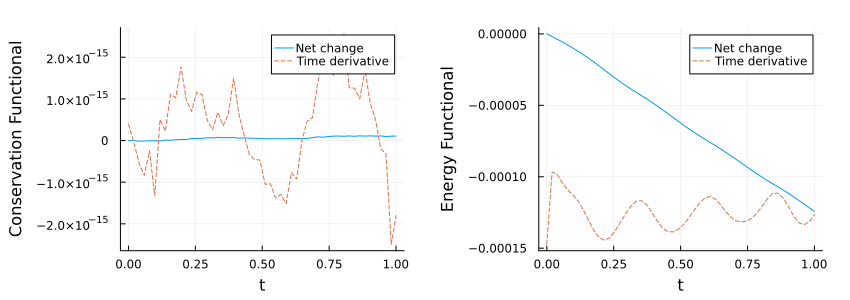

In [7]:
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
energy_analysis = EnergyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
p1 = plot(analyze(conservation_analysis, load_time_steps(results_path)), ylabel="Conservation Functional");
p2 = plot(analyze(energy_analysis, load_time_steps(results_path)), ylabel="Energy Functional");
plot(p1,p2, size=(850,300),margin=5mm)

## Postprocess for VTK visualization

In [8]:
for i in eachindex(sol.u)
    postprocess_vtk(spatial_discretization,
        string(results_path,"vis_", lpad(i,3,"0"), ".vtu"),
            sol.u[i],p_map=p_map,p_vis=p)
end